在 [上一节pytorch深度学习中](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)中，我们向您展示了如何加载数据，如何通过定义为`nn.Module`子类的模型提供数据，如何在训练数据上训练该模型以及在测试数据上对其进行测试。 为了了解发生的情况，我们在模型训练期间打印一些统计数据，以了解训练是否在进行中。 但是，我们可以做得更好：PyTorch 与 TensorBoard 集成在一起，TensorBoard 是一种工具，用于可视化神经网络训练运行的结果。 本教程使用 [Fashion-MNIST 数据集](https://github.com/zalandoresearch/fashion-mnist)说明了其某些功能，可以使用`torchvision.datasets`将其读入 PyTorch。

在本教程中，我们将学习如何：

> 1. 读取数据并进行适当的转换（与先前的教程几乎相同）。
> 2. 设置 TensorBoard。
> 3. 写入 TensorBoard。
> 4. 使用 TensorBoard 检查模型架构。
> 5. 使用 TensorBoard 来创建我们在上一个教程中创建的可视化的交互式版本，并使用较少的代码

具体来说，在第 5 点，我们将看到：

> - 有两种方法可以检查我们的训练数据
> - 在训练模型时如何跟踪其表现
> - 在训练后如何评估模型的表现。

我们将从 [CIFAR-10 教程](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)中类似的样板代码开始：

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

我们将在该教程中定义一个类似的模型架构，仅需进行少量修改即可解决以下事实：图像现在是一个通道而不是三个通道，而图像是28x28而不是32x32：

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1,6,3) #26
        self.pool = nn.MaxPool2d(2,2) #13
        self.conv2 = nn.Conv2d(6,16,3)#11 - 5
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x    
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


## 1. TensorBoard 设置
从`torch.utils`导入`tensorboard`并定义`SummaryWriter`，这是将信息写入 TensorBoard 的关键对象。

In [4]:
from torch.utils.tensorboard import SummaryWriter
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/fashion_mnist_experiment_1')


## 2. 写入 TensorBoard
使用make_grid将图像写入到 TensorBoard 中，具体来说就是网格。

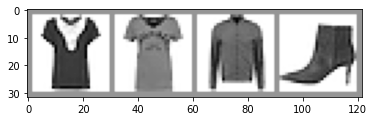

In [5]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)

## 3. 使用 TensorBoard 检查模型
TensorBoard 的优势之一是其可视化复杂模型结构的能力。 让我们可视化我们构建的模型。

In [6]:
writer.add_graph(net, images)


## 4. 在 TensorBoard 中添加“投影仪”

我们可以通过[`add_embedding`](https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.SummaryWriter.add_embedding)方法可视化高维数据的低维表示

In [7]:

#现在刷新 TensorBoard 后，您应该会看到一个Graphs标签 
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(trainset.data, trainset.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))


## 5. 使用 TensorBoard 跟踪模型训练
在前面的示例中，我们仅每 2000 次迭代打印该模型的运行损失。 现在，我们将运行损失记录到 TensorBoard 中，并通过plot_classes_preds函数查看模型所做的预测。

In [8]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

最后，让我们使用与之前教程相同的模型训练代码来训练模型，但是每 1000 批将结果写入 TensorBoard，而不是打印到控制台。 这是通过add_scalar函数完成的。

此外，在训练过程中，我们将生成一幅图像，显示该批量中包含的四幅图像的模型预测与实际结果。

In [9]:
running_loss = 0.0
for epoch in range(1):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
writer.close()

print('Finished Training')

Finished Training


## 6. 使用 TensorBoard 评估经过训练的模型

In [10]:
# 1\. gets the probability predictions in a test_size x num_classes Tensor
# 2\. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_preds = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)

In [ ]:
!tensorboard --logdir=runs
#从命令行，然后导航到https://localhost:6006应该显示以下内容。

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.6.0 at http://localhost:6006/ (Press CTRL+C to quit)
